In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys
from numba import njit, jit
from math import isnan
from sklearn.preprocessing import MinMaxScaler

In [62]:
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"
#Clean Light Curves
lc_kepler = np.load(folder_lc+"npy/KOI_LC_init.npy")
lc_kepler_times = np.load(folder_lc+'npy/KOI_LC_time.npy')

In [63]:
total_time_list = []
for lc,times in zip(lc_kepler,lc_kepler_times):
    time_list = []
    aux_t = times[0]
    for i, data in enumerate(lc):
        if not isnan(data):
            time_list.append(times[i] - aux_t)
        else:
            time_list.append(np.nan)
            #time_list.append(0)
            if (times[i] != times[-1]):
                aux_t = times[i+1]
    total_time_list.append(time_list)

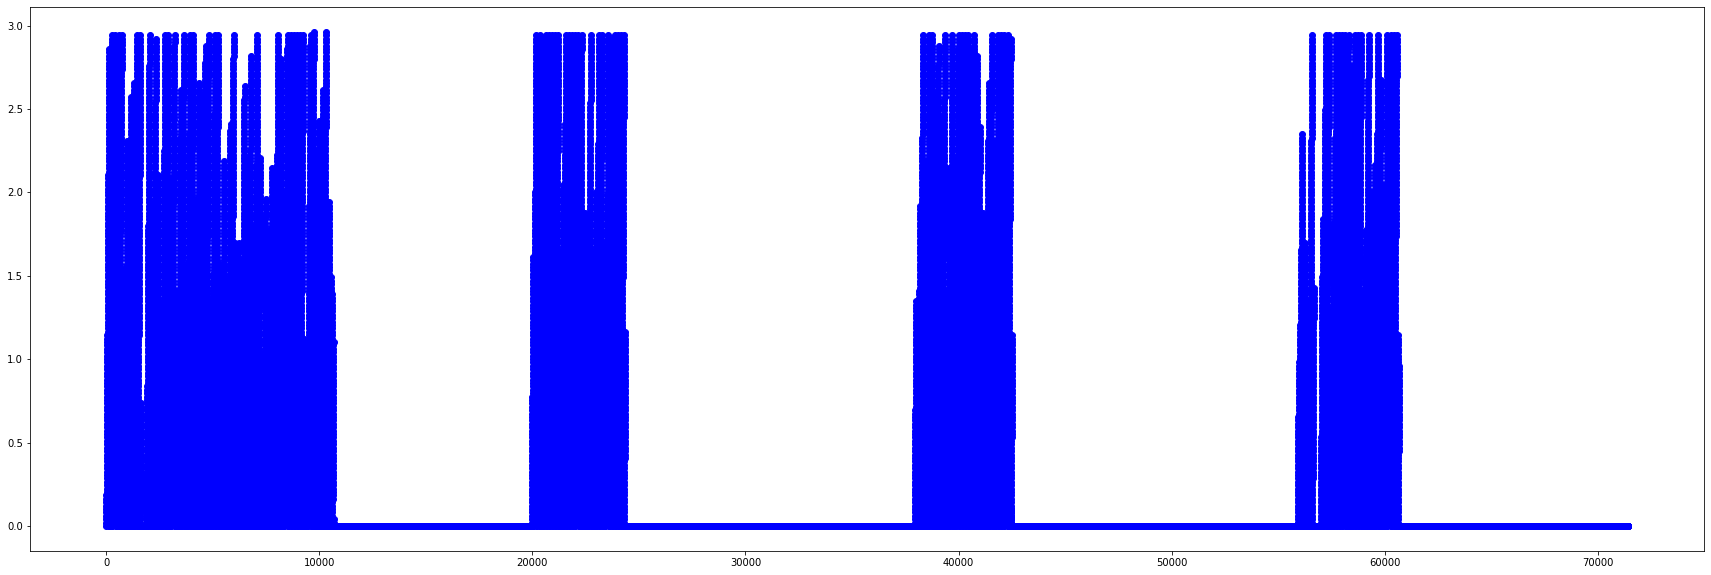

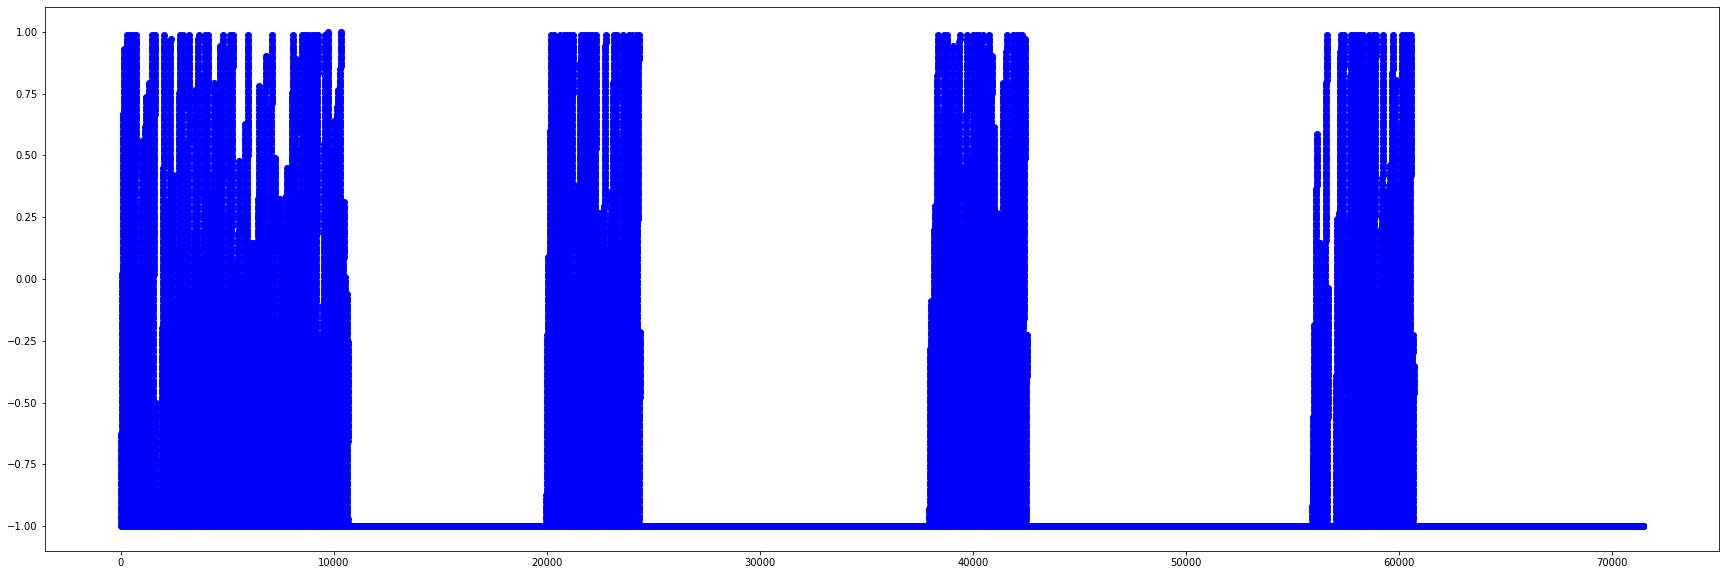

In [54]:
indice = 14
plt.figure(figsize=(30,10))
plt.plot(total_time_list[indice],'bo')
plt.show()


trasnform_curve = prepare_lc(total_time_list[indice])
plt.figure(figsize=(30,10))
plt.plot(trasnform_curve,'bo')
plt.show()

## Valores entre -1 y 1

In [66]:
## no python: njit -- no soporta lista de lista, lista de arrays, si soporta: lista de sets

########### no lo logre hacer funcionar
#@njit(parallel=True, cache=False, fastmath=True)
def extract_nans(fluxs, plot=True):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = [] #para que sepa que el tipo es float
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = [] #para que sepa que el tipo es float
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 

    if plot:
        lengths = np.asarray(lengths)   
        #print("Cantidad de tramos: ",len(lengths))
        #print("Largo promedio de tramos: ", np.mean(lengths))
        #print("Mediana de largo de tramos: ", np.median(lengths))
        #print("Min de largo de tramos: ", np.min(lengths))
        #print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan


def prepare_lc(fluxs): #dividir por max
    fluxs = np.asarray(fluxs)
    fluxs = fluxs.reshape(-1,1)
    scaler = MinMaxScaler((-1, 1))
    scaler.fit(fluxs)
    fluxs = scaler.transform(fluxs)
    fluxs = fluxs.ravel()
    return fluxs#fluxs/np.abs(np.nanmin(fluxs))

@njit(parallel=True, cache=False, fastmath=True)
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

@njit(parallel=False, cache=True, fastmath=True)
def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return estados_up + estados_low

@njit(parallel=False, cache=True, fastmath=True)
def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    return 0 #if sale por arriba (mayor a 1)

@njit(parallel=False, cache=True, fastmath=True)  #no se pudo paralelizar por el acceso a lista "ind -1"
def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

@njit(parallel=True, cache=False, fastmath=True)
def manual_HMM(wind_fluxs, n_sta_up, n_sta_low=0):
    if n_sta_low == 0: 
        n_sta_low = n_sta_up 
    n_sta = n_sta_up+n_sta_low
    
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(1,-1, n_sta_up=n_sta_up, n_sta_low=n_sta_low) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    
    for i in range(n_sta):
        suma_i = 0
        for j in range(n_sta):
            transition_m[i,j] +=1 #priors
            suma_i += transition_m[i,j]
        transition_m[i] = transition_m[i]/suma_i #normalize
    return transition_m


In [68]:
%%time
final_npy = []
i=0
for lc_our_detrend in total_time_list:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    plt.imshow(fluxs)
    plt.show()
    lc_tramos =  extract_nans(fluxs) #extract nans  
    transition_m = manual_HMM(lc_tramos, n_sta_up=15, n_sta_low=15) #si se dejan 5 arriba y 10 abajo cambia harto...

    i+=1
    plt.imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    plt.show()
    final_npy.append(transition_m)

recuperando curva 1
recuperando curva 2
recuperando curva 3
recuperando curva 4
recuperando curva 5
recuperando curva 6
recuperando curva 7
recuperando curva 8
recuperando curva 9
recuperando curva 10
recuperando curva 11
recuperando curva 12
recuperando curva 13
recuperando curva 14
recuperando curva 15
recuperando curva 16
recuperando curva 17
recuperando curva 18
recuperando curva 19
recuperando curva 20
recuperando curva 21
recuperando curva 22
recuperando curva 23
recuperando curva 24
recuperando curva 25
recuperando curva 26
recuperando curva 27
recuperando curva 28
recuperando curva 29
recuperando curva 30
recuperando curva 31
recuperando curva 32
recuperando curva 33
recuperando curva 34
recuperando curva 35
recuperando curva 36
recuperando curva 37
recuperando curva 38
recuperando curva 39
recuperando curva 40
recuperando curva 41
recuperando curva 42
recuperando curva 43
recuperando curva 44
recuperando curva 45
recuperando curva 46
recuperando curva 47
recuperando curva 48
r

recuperando curva 379
recuperando curva 380
recuperando curva 381
recuperando curva 382
recuperando curva 383
recuperando curva 384
recuperando curva 385
recuperando curva 386
recuperando curva 387
recuperando curva 388
recuperando curva 389
recuperando curva 390
recuperando curva 391
recuperando curva 392
recuperando curva 393
recuperando curva 394
recuperando curva 395
recuperando curva 396
recuperando curva 397
recuperando curva 398
recuperando curva 399
recuperando curva 400
recuperando curva 401
recuperando curva 402
recuperando curva 403
recuperando curva 404
recuperando curva 405
recuperando curva 406
recuperando curva 407
recuperando curva 408
recuperando curva 409
recuperando curva 410
recuperando curva 411
recuperando curva 412
recuperando curva 413
recuperando curva 414
recuperando curva 415
recuperando curva 416
recuperando curva 417
recuperando curva 418
recuperando curva 419
recuperando curva 420
recuperando curva 421
recuperando curva 422
recuperando curva 423
recuperand

recuperando curva 752
recuperando curva 753
recuperando curva 754
recuperando curva 755
recuperando curva 756
recuperando curva 757
recuperando curva 758
recuperando curva 759
recuperando curva 760
recuperando curva 761
recuperando curva 762
recuperando curva 763
recuperando curva 764
recuperando curva 765
recuperando curva 766
recuperando curva 767
recuperando curva 768
recuperando curva 769
recuperando curva 770
recuperando curva 771
recuperando curva 772
recuperando curva 773
recuperando curva 774
recuperando curva 775
recuperando curva 776
recuperando curva 777
recuperando curva 778
recuperando curva 779
recuperando curva 780
recuperando curva 781
recuperando curva 782
recuperando curva 783
recuperando curva 784
recuperando curva 785
recuperando curva 786
recuperando curva 787
recuperando curva 788
recuperando curva 789
recuperando curva 790
recuperando curva 791
recuperando curva 792
recuperando curva 793
recuperando curva 794
recuperando curva 795
recuperando curva 796
recuperand

recuperando curva 1119
recuperando curva 1120
recuperando curva 1121
recuperando curva 1122
recuperando curva 1123
recuperando curva 1124
recuperando curva 1125
recuperando curva 1126
recuperando curva 1127
recuperando curva 1128
recuperando curva 1129
recuperando curva 1130
recuperando curva 1131
recuperando curva 1132
recuperando curva 1133
recuperando curva 1134
recuperando curva 1135
recuperando curva 1136
recuperando curva 1137
recuperando curva 1138
recuperando curva 1139
recuperando curva 1140
recuperando curva 1141
recuperando curva 1142
recuperando curva 1143
recuperando curva 1144
recuperando curva 1145
recuperando curva 1146
recuperando curva 1147
recuperando curva 1148
recuperando curva 1149
recuperando curva 1150
recuperando curva 1151
recuperando curva 1152
recuperando curva 1153
recuperando curva 1154
recuperando curva 1155
recuperando curva 1156
recuperando curva 1157
recuperando curva 1158
recuperando curva 1159
recuperando curva 1160
recuperando curva 1161
recuperando

recuperando curva 1476
recuperando curva 1477
recuperando curva 1478
recuperando curva 1479
recuperando curva 1480
recuperando curva 1481
recuperando curva 1482
recuperando curva 1483
recuperando curva 1484
recuperando curva 1485
recuperando curva 1486
recuperando curva 1487
recuperando curva 1488
recuperando curva 1489
recuperando curva 1490
recuperando curva 1491
recuperando curva 1492
recuperando curva 1493
recuperando curva 1494
recuperando curva 1495
recuperando curva 1496
recuperando curva 1497
recuperando curva 1498
recuperando curva 1499
recuperando curva 1500
recuperando curva 1501
recuperando curva 1502
recuperando curva 1503
recuperando curva 1504
recuperando curva 1505
recuperando curva 1506
recuperando curva 1507
recuperando curva 1508
recuperando curva 1509
recuperando curva 1510
recuperando curva 1511
recuperando curva 1512
recuperando curva 1513
recuperando curva 1514
recuperando curva 1515
recuperando curva 1516
recuperando curva 1517
recuperando curva 1518
recuperando

recuperando curva 1833
recuperando curva 1834
recuperando curva 1835
recuperando curva 1836
recuperando curva 1837
recuperando curva 1838
recuperando curva 1839
recuperando curva 1840
recuperando curva 1841
recuperando curva 1842
recuperando curva 1843
recuperando curva 1844
recuperando curva 1845
recuperando curva 1846
recuperando curva 1847
recuperando curva 1848
recuperando curva 1849
recuperando curva 1850
recuperando curva 1851
recuperando curva 1852
recuperando curva 1853
recuperando curva 1854
recuperando curva 1855
recuperando curva 1856
recuperando curva 1857
recuperando curva 1858
recuperando curva 1859
recuperando curva 1860
recuperando curva 1861
recuperando curva 1862
recuperando curva 1863
recuperando curva 1864
recuperando curva 1865
recuperando curva 1866
recuperando curva 1867
recuperando curva 1868
recuperando curva 1869
recuperando curva 1870
recuperando curva 1871
recuperando curva 1872
recuperando curva 1873
recuperando curva 1874
recuperando curva 1875
recuperando

recuperando curva 2190
recuperando curva 2191
recuperando curva 2192
recuperando curva 2193
recuperando curva 2194
recuperando curva 2195
recuperando curva 2196
recuperando curva 2197
recuperando curva 2198
recuperando curva 2199
recuperando curva 2200
recuperando curva 2201
recuperando curva 2202
recuperando curva 2203
recuperando curva 2204
recuperando curva 2205
recuperando curva 2206
recuperando curva 2207
recuperando curva 2208
recuperando curva 2209
recuperando curva 2210
recuperando curva 2211
recuperando curva 2212
recuperando curva 2213
recuperando curva 2214
recuperando curva 2215
recuperando curva 2216
recuperando curva 2217
recuperando curva 2218
recuperando curva 2219
recuperando curva 2220
recuperando curva 2221
recuperando curva 2222
recuperando curva 2223
recuperando curva 2224
recuperando curva 2225
recuperando curva 2226
recuperando curva 2227
recuperando curva 2228
recuperando curva 2229
recuperando curva 2230
recuperando curva 2231
recuperando curva 2232
recuperando

recuperando curva 2547
recuperando curva 2548
recuperando curva 2549
recuperando curva 2550
recuperando curva 2551
recuperando curva 2552
recuperando curva 2553
recuperando curva 2554
recuperando curva 2555
recuperando curva 2556
recuperando curva 2557
recuperando curva 2558
recuperando curva 2559
recuperando curva 2560
recuperando curva 2561
recuperando curva 2562
recuperando curva 2563
recuperando curva 2564
recuperando curva 2565
recuperando curva 2566
recuperando curva 2567
recuperando curva 2568
recuperando curva 2569
recuperando curva 2570
recuperando curva 2571
recuperando curva 2572
recuperando curva 2573
recuperando curva 2574
recuperando curva 2575
recuperando curva 2576
recuperando curva 2577
recuperando curva 2578
recuperando curva 2579
recuperando curva 2580
recuperando curva 2581
recuperando curva 2582
recuperando curva 2583
recuperando curva 2584
recuperando curva 2585
recuperando curva 2586
recuperando curva 2587
recuperando curva 2588
recuperando curva 2589
recuperando

recuperando curva 2904
recuperando curva 2905
recuperando curva 2906
recuperando curva 2907
recuperando curva 2908
recuperando curva 2909
recuperando curva 2910
recuperando curva 2911
recuperando curva 2912
recuperando curva 2913
recuperando curva 2914
recuperando curva 2915
recuperando curva 2916
recuperando curva 2917
recuperando curva 2918
recuperando curva 2919
recuperando curva 2920
recuperando curva 2921
recuperando curva 2922
recuperando curva 2923
recuperando curva 2924
recuperando curva 2925
recuperando curva 2926
recuperando curva 2927
recuperando curva 2928
recuperando curva 2929
recuperando curva 2930
recuperando curva 2931
recuperando curva 2932
recuperando curva 2933
recuperando curva 2934
recuperando curva 2935
recuperando curva 2936
recuperando curva 2937
recuperando curva 2938
recuperando curva 2939
recuperando curva 2940
recuperando curva 2941
recuperando curva 2942
recuperando curva 2943
recuperando curva 2944
recuperando curva 2945
recuperando curva 2946
recuperando

recuperando curva 3261
recuperando curva 3262
recuperando curva 3263
recuperando curva 3264
recuperando curva 3265
recuperando curva 3266
recuperando curva 3267
recuperando curva 3268
recuperando curva 3269
recuperando curva 3270
recuperando curva 3271
recuperando curva 3272
recuperando curva 3273
recuperando curva 3274
recuperando curva 3275
recuperando curva 3276
recuperando curva 3277
recuperando curva 3278
recuperando curva 3279
recuperando curva 3280
recuperando curva 3281
recuperando curva 3282
recuperando curva 3283
recuperando curva 3284
recuperando curva 3285
recuperando curva 3286
recuperando curva 3287
recuperando curva 3288
recuperando curva 3289
recuperando curva 3290
recuperando curva 3291
recuperando curva 3292
recuperando curva 3293
recuperando curva 3294
recuperando curva 3295
recuperando curva 3296
recuperando curva 3297
recuperando curva 3298
recuperando curva 3299
recuperando curva 3300
recuperando curva 3301
recuperando curva 3302
recuperando curva 3303
recuperando

recuperando curva 3618
recuperando curva 3619
recuperando curva 3620
recuperando curva 3621
recuperando curva 3622
recuperando curva 3623
recuperando curva 3624
recuperando curva 3625
recuperando curva 3626
recuperando curva 3627
recuperando curva 3628
recuperando curva 3629
recuperando curva 3630
recuperando curva 3631
recuperando curva 3632
recuperando curva 3633
recuperando curva 3634
recuperando curva 3635
recuperando curva 3636
recuperando curva 3637
recuperando curva 3638
recuperando curva 3639
recuperando curva 3640
recuperando curva 3641
recuperando curva 3642
recuperando curva 3643
recuperando curva 3644
recuperando curva 3645
recuperando curva 3646
recuperando curva 3647
recuperando curva 3648
recuperando curva 3649
recuperando curva 3650
recuperando curva 3651
recuperando curva 3652
recuperando curva 3653
recuperando curva 3654
recuperando curva 3655
recuperando curva 3656
recuperando curva 3657
recuperando curva 3658
recuperando curva 3659
recuperando curva 3660
recuperando

recuperando curva 3975
recuperando curva 3976
recuperando curva 3977
recuperando curva 3978
recuperando curva 3979
recuperando curva 3980
recuperando curva 3981
recuperando curva 3982
recuperando curva 3983
recuperando curva 3984
recuperando curva 3985
recuperando curva 3986
recuperando curva 3987
recuperando curva 3988
recuperando curva 3989
recuperando curva 3990
recuperando curva 3991
recuperando curva 3992
recuperando curva 3993
recuperando curva 3994
recuperando curva 3995
recuperando curva 3996
recuperando curva 3997
recuperando curva 3998
recuperando curva 3999
recuperando curva 4000
recuperando curva 4001
recuperando curva 4002
recuperando curva 4003
recuperando curva 4004
recuperando curva 4005
recuperando curva 4006
recuperando curva 4007
recuperando curva 4008
recuperando curva 4009
recuperando curva 4010
recuperando curva 4011
recuperando curva 4012
recuperando curva 4013
recuperando curva 4014
recuperando curva 4015
recuperando curva 4016
recuperando curva 4017
recuperando

recuperando curva 4332
recuperando curva 4333
recuperando curva 4334
recuperando curva 4335
recuperando curva 4336
recuperando curva 4337
recuperando curva 4338
recuperando curva 4339
recuperando curva 4340
recuperando curva 4341
recuperando curva 4342
recuperando curva 4343
recuperando curva 4344
recuperando curva 4345
recuperando curva 4346
recuperando curva 4347
recuperando curva 4348
recuperando curva 4349
recuperando curva 4350
recuperando curva 4351
recuperando curva 4352
recuperando curva 4353
recuperando curva 4354
recuperando curva 4355
recuperando curva 4356
recuperando curva 4357
recuperando curva 4358
recuperando curva 4359
recuperando curva 4360
recuperando curva 4361
recuperando curva 4362
recuperando curva 4363
recuperando curva 4364
recuperando curva 4365
recuperando curva 4366
recuperando curva 4367
recuperando curva 4368
recuperando curva 4369
recuperando curva 4370
recuperando curva 4371
recuperando curva 4372
recuperando curva 4373
recuperando curva 4374
recuperando

recuperando curva 4689
recuperando curva 4690
recuperando curva 4691
recuperando curva 4692
recuperando curva 4693
recuperando curva 4694
recuperando curva 4695
recuperando curva 4696
recuperando curva 4697
recuperando curva 4698
recuperando curva 4699
recuperando curva 4700
recuperando curva 4701
recuperando curva 4702
recuperando curva 4703
recuperando curva 4704
recuperando curva 4705
recuperando curva 4706
recuperando curva 4707
recuperando curva 4708
recuperando curva 4709
recuperando curva 4710
recuperando curva 4711
recuperando curva 4712
recuperando curva 4713
recuperando curva 4714
recuperando curva 4715
recuperando curva 4716
recuperando curva 4717
recuperando curva 4718
recuperando curva 4719
recuperando curva 4720
recuperando curva 4721
recuperando curva 4722
recuperando curva 4723
recuperando curva 4724
recuperando curva 4725
recuperando curva 4726
recuperando curva 4727
recuperando curva 4728
recuperando curva 4729
recuperando curva 4730
recuperando curva 4731
recuperando

recuperando curva 5046
recuperando curva 5047
recuperando curva 5048
recuperando curva 5049
recuperando curva 5050
recuperando curva 5051
recuperando curva 5052
recuperando curva 5053
recuperando curva 5054
recuperando curva 5055
recuperando curva 5056
recuperando curva 5057
recuperando curva 5058
recuperando curva 5059
recuperando curva 5060
recuperando curva 5061
recuperando curva 5062
recuperando curva 5063
recuperando curva 5064
recuperando curva 5065
recuperando curva 5066
recuperando curva 5067
recuperando curva 5068
recuperando curva 5069
recuperando curva 5070
recuperando curva 5071
recuperando curva 5072
recuperando curva 5073
recuperando curva 5074
recuperando curva 5075
recuperando curva 5076
recuperando curva 5077
recuperando curva 5078
recuperando curva 5079
recuperando curva 5080
recuperando curva 5081
recuperando curva 5082
recuperando curva 5083
recuperando curva 5084
recuperando curva 5085
recuperando curva 5086
recuperando curva 5087
recuperando curva 5088
recuperando

recuperando curva 5403
recuperando curva 5404
recuperando curva 5405
recuperando curva 5406
recuperando curva 5407
recuperando curva 5408
recuperando curva 5409
recuperando curva 5410
recuperando curva 5411
recuperando curva 5412
recuperando curva 5413
recuperando curva 5414
recuperando curva 5415
recuperando curva 5416
recuperando curva 5417
recuperando curva 5418
recuperando curva 5419
recuperando curva 5420
recuperando curva 5421
recuperando curva 5422
recuperando curva 5423
recuperando curva 5424
recuperando curva 5425
recuperando curva 5426
recuperando curva 5427
recuperando curva 5428
recuperando curva 5429
recuperando curva 5430
recuperando curva 5431
recuperando curva 5432
recuperando curva 5433
recuperando curva 5434
recuperando curva 5435
recuperando curva 5436
recuperando curva 5437
recuperando curva 5438
recuperando curva 5439
recuperando curva 5440
recuperando curva 5441
recuperando curva 5442
recuperando curva 5443
recuperando curva 5444
recuperando curva 5445
recuperando

recuperando curva 5760
recuperando curva 5761
recuperando curva 5762
recuperando curva 5763
recuperando curva 5764
recuperando curva 5765
recuperando curva 5766
recuperando curva 5767
recuperando curva 5768
recuperando curva 5769
recuperando curva 5770
recuperando curva 5771
recuperando curva 5772
recuperando curva 5773
recuperando curva 5774
recuperando curva 5775
recuperando curva 5776
recuperando curva 5777
recuperando curva 5778
recuperando curva 5779
recuperando curva 5780
recuperando curva 5781
recuperando curva 5782
recuperando curva 5783
recuperando curva 5784
recuperando curva 5785
recuperando curva 5786
recuperando curva 5787
recuperando curva 5788
recuperando curva 5789
recuperando curva 5790
recuperando curva 5791
recuperando curva 5792
recuperando curva 5793
recuperando curva 5794
recuperando curva 5795
recuperando curva 5796
recuperando curva 5797
recuperando curva 5798
recuperando curva 5799
recuperando curva 5800
recuperando curva 5801
recuperando curva 5802
recuperando

recuperando curva 6117
recuperando curva 6118
recuperando curva 6119
recuperando curva 6120
recuperando curva 6121
recuperando curva 6122
recuperando curva 6123
recuperando curva 6124
recuperando curva 6125
recuperando curva 6126
recuperando curva 6127
recuperando curva 6128
recuperando curva 6129
recuperando curva 6130
recuperando curva 6131
recuperando curva 6132
recuperando curva 6133
recuperando curva 6134
recuperando curva 6135
recuperando curva 6136
recuperando curva 6137
recuperando curva 6138
recuperando curva 6139
recuperando curva 6140
recuperando curva 6141
recuperando curva 6142
recuperando curva 6143
recuperando curva 6144
recuperando curva 6145
recuperando curva 6146
recuperando curva 6147
recuperando curva 6148
recuperando curva 6149
recuperando curva 6150
recuperando curva 6151
recuperando curva 6152
recuperando curva 6153
recuperando curva 6154
recuperando curva 6155
recuperando curva 6156
recuperando curva 6157
recuperando curva 6158
recuperando curva 6159
recuperando

recuperando curva 6474
recuperando curva 6475
recuperando curva 6476
recuperando curva 6477
recuperando curva 6478
recuperando curva 6479
recuperando curva 6480
recuperando curva 6481
recuperando curva 6482
recuperando curva 6483
recuperando curva 6484
recuperando curva 6485
recuperando curva 6486
recuperando curva 6487
recuperando curva 6488
recuperando curva 6489
recuperando curva 6490
recuperando curva 6491
recuperando curva 6492
recuperando curva 6493
recuperando curva 6494
recuperando curva 6495
recuperando curva 6496
recuperando curva 6497
recuperando curva 6498
recuperando curva 6499
recuperando curva 6500
recuperando curva 6501
recuperando curva 6502
recuperando curva 6503
recuperando curva 6504
recuperando curva 6505
recuperando curva 6506
recuperando curva 6507
recuperando curva 6508
recuperando curva 6509
recuperando curva 6510
recuperando curva 6511
recuperando curva 6512
recuperando curva 6513
recuperando curva 6514
recuperando curva 6515
recuperando curva 6516
recuperando

recuperando curva 6831
recuperando curva 6832
recuperando curva 6833
recuperando curva 6834
recuperando curva 6835
recuperando curva 6836
recuperando curva 6837
recuperando curva 6838
recuperando curva 6839
recuperando curva 6840
recuperando curva 6841
recuperando curva 6842
recuperando curva 6843
recuperando curva 6844
recuperando curva 6845
recuperando curva 6846
recuperando curva 6847
recuperando curva 6848
recuperando curva 6849
recuperando curva 6850
recuperando curva 6851
recuperando curva 6852
recuperando curva 6853
recuperando curva 6854
recuperando curva 6855
recuperando curva 6856
recuperando curva 6857
recuperando curva 6858
recuperando curva 6859
recuperando curva 6860
recuperando curva 6861
recuperando curva 6862
recuperando curva 6863
recuperando curva 6864
recuperando curva 6865
recuperando curva 6866
recuperando curva 6867
recuperando curva 6868
recuperando curva 6869
recuperando curva 6870
recuperando curva 6871
recuperando curva 6872
recuperando curva 6873
recuperando

recuperando curva 7188
recuperando curva 7189
recuperando curva 7190
recuperando curva 7191
recuperando curva 7192
recuperando curva 7193
recuperando curva 7194
recuperando curva 7195
recuperando curva 7196
recuperando curva 7197
recuperando curva 7198
recuperando curva 7199
recuperando curva 7200
recuperando curva 7201
recuperando curva 7202
recuperando curva 7203
recuperando curva 7204
recuperando curva 7205
recuperando curva 7206
recuperando curva 7207
recuperando curva 7208
recuperando curva 7209
recuperando curva 7210
recuperando curva 7211
recuperando curva 7212
recuperando curva 7213
recuperando curva 7214
recuperando curva 7215
recuperando curva 7216
recuperando curva 7217
recuperando curva 7218
recuperando curva 7219
recuperando curva 7220
recuperando curva 7221
recuperando curva 7222
recuperando curva 7223
recuperando curva 7224
recuperando curva 7225
recuperando curva 7226
recuperando curva 7227
recuperando curva 7228
recuperando curva 7229
recuperando curva 7230
recuperando

recuperando curva 7545
recuperando curva 7546
recuperando curva 7547
recuperando curva 7548
recuperando curva 7549
recuperando curva 7550
recuperando curva 7551
recuperando curva 7552
recuperando curva 7553
recuperando curva 7554
recuperando curva 7555
recuperando curva 7556
recuperando curva 7557
recuperando curva 7558
recuperando curva 7559
recuperando curva 7560
recuperando curva 7561
recuperando curva 7562
recuperando curva 7563
recuperando curva 7564
recuperando curva 7565
recuperando curva 7566
recuperando curva 7567
recuperando curva 7568
recuperando curva 7569
recuperando curva 7570
recuperando curva 7571
recuperando curva 7572
recuperando curva 7573
recuperando curva 7574
recuperando curva 7575
recuperando curva 7576
recuperando curva 7577
recuperando curva 7578
recuperando curva 7579
recuperando curva 7580
recuperando curva 7581
recuperando curva 7582
recuperando curva 7583
recuperando curva 7584
recuperando curva 7585
recuperando curva 7586
recuperando curva 7587
recuperando

recuperando curva 7902
recuperando curva 7903
recuperando curva 7904
recuperando curva 7905
recuperando curva 7906
recuperando curva 7907
recuperando curva 7908
recuperando curva 7909
recuperando curva 7910
recuperando curva 7911
recuperando curva 7912
recuperando curva 7913
recuperando curva 7914
recuperando curva 7915
recuperando curva 7916
recuperando curva 7917
recuperando curva 7918
recuperando curva 7919
recuperando curva 7920
recuperando curva 7921
recuperando curva 7922
recuperando curva 7923
recuperando curva 7924
recuperando curva 7925
recuperando curva 7926
recuperando curva 7927
recuperando curva 7928
recuperando curva 7929
recuperando curva 7930
recuperando curva 7931
recuperando curva 7932
recuperando curva 7933
recuperando curva 7934
recuperando curva 7935
recuperando curva 7936
recuperando curva 7937
recuperando curva 7938
recuperando curva 7939
recuperando curva 7940
recuperando curva 7941
recuperando curva 7942
recuperando curva 7943
recuperando curva 7944
recuperando

In [69]:
final_npy = np.asarray(final_npy)
np.save('./time_channel_30.npy', final_npy)